# Imports

In [1]:
# General
import pandas as pd
import numpy as np
import os, ast
pd.set_option('display.max_colwidth', -1)
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import pickle


# Visualisation
import seaborn as sns
from IPython.display import display_html
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from IPython.core.display import display, HTML


#Algorithms
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
import pingouin as pg
from sklearn.metrics import r2_score

# Model Explainability
import shap
import eli5
import lime
from pdpbox import pdp, get_dataset, info_plots
from IPython.display import Image
from sklearn import tree
import pydotplus

# Paths & Variable Initializations

In [2]:
####### Path #######
root_path = '../'
data_path = root_path+'Data/'
raw_data_path = data_path+'Raw Data/'

complete_data_path = raw_data_path+'Data.csv'

prepared_data_path = data_path+'Prepared Data/'

notebook_results_path = root_path+'Notebook Results/'
os.makedirs(notebook_results_path, exist_ok=True)

#################VARIABLE INITIALISATIONS#####################
TARGET_VARIABLE = 'SalePrice'

plt.rcParams['figure.dpi']     = 140
plt.rcParams['figure.figsize'] = (25,5)

# Helper Functions

In [3]:
class HelperFunctions:
    def __init__(self):
        print('Initialising the Helper Fucntion Class..')
        

    def display_side_by_side(self, dfs:list, captions:list):
        """Display tables side by side to save vertical space
        Input:
            dfs: list of pandas.DataFrame
            captions: list of table captions
        """
        output = ""
        combined = dict(zip(captions, dfs))
        for caption, df in combined.items():
            output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
            output += "\xa0\xa0\xa0"
        display(HTML(output))
        
helperFunctionsHandler = HelperFunctions()


Initialising the Helper Fucntion Class..


# Reading, Preparing and Splitting the data

## Reading the data

In [23]:
complete_data = pd.read_csv(complete_data_path, index_col=0,low_memory=False)
print('Complete Data Contains : ', complete_data.shape)
print('Number of Duplicate Indexes in the data : ', complete_data.index.duplicated().sum())
complete_data.head(2)
idx = 0

Complete Data Contains :  (401125, 52)
Number of Duplicate Indexes in the data :  0


,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
SalesID,,,,,,,,,,,,,,,,,,,,,
1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


## Analysing the individual columns

In [25]:
## Analysing the data - You gotta go through each column one by one

colAnalysed = complete_data.columns[idx]
print('Column Being Analysed : ', colAnalysed)

helperFunctionsHandler.display_side_by_side([complete_data[[colAnalysed]].sample(7),
                                             complete_data[[colAnalysed]].describe()],
                                             captions = ['Raw Data', 'Descriptive Statistics'])
idx += 1


Column Being Analysed :  SalePrice


,SalePrice
SalesID,
1252365,20000
2249329,55000
2273093,41000
1429479,26000
1639502,21000
2201976,7000
1799424,8500
,SalePrice
count,401125


- Target Column might be left skewed
- MachineID is not an unique identifier, as many vehicles were again auctioned
- ModelID is not an unique identifier, might be categorical
- datasource is an useless column, should be dropped
- auctioneerID is an categorical column
- There are 38185 data points in which YearMade is 1000 -- Junk Data
- Most of the data in 'MachineHoursCurrentMeter' is NaN -- replace it with -999
- UsageBand is categorical and should be ordered in order = ['High', 'Medium', 'Low]
- saledate is a date column. Parse it
- fiModelDesc, fiBaseModel, fiSecondaryDesc, fiModelSeries, fiModelDescriptor, fiProductClassDesc - All are categorical columns, and the missing values should be replaced wiith -999
- ProductSize is an categorical Size column
- state is an categorical column
- ProductGroup, ProductGroupDesc, Drive_System, Enclosure, Forks, Pad_Type, Ride_Control, Stick, Transmission, Turbocharged, Blade_Extension, Blade_Width, Enclosure_Type, Engine_Horsepower, Hydraulics, Pushblock, Ripper, Scarifier, Tip_Control, Tire_Size, Coupler, Coupler_System, Grouser_Tracks, Hydraulics_Flow, Track_Type, Undercarriage_Pad_Width, Stick_Length, Thumb, Pattern_Changer, Grouser_Type, Backhoe_Mounting, Blade_Type, Travel_Controls, Differential_Type, Steering_Controls,    are categorical

## Some Analysis

In [56]:
ax = complete_data.YearMade.value_counts().sort_index().plot(kind='bar')
_=plt.xticks(rotation=70)
_=plt.xlabel('Years',fontsize=20)
_=plt.ylabel('Counts',fontsize=20)
_=plt.title('Number of vehicles by manufacture year',fontsize=30)
plt.savefig(notebook_results_path+'YearCounts.jpg', bbox_inches='tight')
plt.close()

In [57]:
descriptiveDF = pd.DataFrame(complete_data.isna().sum(), columns=['Null Count']).sort_values('Null Count')
descriptiveDF['Null Count Percent'] = complete_data.isna().sum()/complete_data.shape[0]
descriptiveDF['Uniques'] = complete_data.nunique()
descriptiveDF['PercentUniques'] = 1 - (complete_data.nunique()/complete_data.count())

# Analysing the Null Values
_=plt.bar(x="index", height="Null Count Percent", data=descriptiveDF.reset_index(),edgecolor='k')
_=plt.xticks(rotation=70)
_=plt.xlabel('Feature',fontsize=20)
_=plt.ylabel('% Null',fontsize=20)
_=plt.title('% of Null Values in Features',fontsize=30)
for i, rows in descriptiveDF.iterrows():
    plt.annotate(rows["Null Count"], xy=(i, 0.5),
                 fontsize=15, rotation=90, color="k", ha='center')
_=plt.savefig(notebook_results_path+'null.jpg', bbox_inches='tight')
plt.close()

# Analysing the Columns that might be Categorical
_=plt.bar(x="index", height="PercentUniques", data=descriptiveDF.reset_index(),
          edgecolor='k', color='orange')
_=plt.xticks(rotation=70)
_=plt.xlabel('Feature',fontsize=20)
_=plt.ylabel('Categorical',fontsize=20)
_=plt.title('Chance of a Feature being Categorical',fontsize=30)

for i, rows in descriptiveDF.iterrows():
    plt.annotate(rows["Uniques"], xy=(i, 0.5),
                 fontsize=15, rotation=90, color="k", ha='center')
    
_=plt.savefig(notebook_results_path+'unique.jpg', bbox_inches='tight')
plt.close()




## Preparing the data

In [26]:
columns_to_be_removed = ['datasource', 'MachineID']
complete_data.drop(columns_to_be_removed, axis=1, inplace=True)

In [28]:
## Replacing those datapoints in 'YearMade' column which had 1000 as the Year.
complete_data.YearMade = complete_data.YearMade.replace({1000 : -999})

In [29]:
complete_data.saledate = pd.to_datetime(complete_data.saledate)

In [31]:
categorical_mapping = {}
for eachCol in complete_data.columns[complete_data.dtypes == 'object']:
    
    if eachCol == 'UsageBand':
        tempCat = pd.Categorical(complete_data[eachCol], categories=['Low', 'Medium', 'High'], ordered=True)
    else:
        tempCat = pd.Categorical(complete_data[eachCol])
    complete_data[eachCol] = tempCat.codes
    categorical_mapping[eachCol] = tempCat

## Splitting the data

In [32]:
split_ratio = 0.05
test_datapoints  = int(split_ratio * complete_data.shape[0])
train_data = complete_data[:-test_datapoints]
test_data = complete_data[-test_datapoints:]
print('Shape of the Training Data : ', train_data.shape)
print('Shape of the Testing Data : ', test_data.shape)

train_data.to_csv(prepared_data_path+'TrainData.csv')
test_data.to_csv(prepared_data_path+'TestData.csv')

Shape of the Training Data :  (381069, 50)
Shape of the Testing Data :  (20056, 50)


In [33]:
pd.DataFrame(train_data.dtypes.value_counts(), columns=['Count'])

,Count
int8,40
int16,4
int64,3
float64,2
datetime64[ns],1


# Feature Engineering

In [ ]:
train_data_EDA = train_data.copy()

## Adding Calendar Variables

In [ ]:
train_data_EDA['sale_year'] = train_data_EDA['saledate'].apply(lambda x :  x.year)
train_data_EDA['sale_month'] = train_data_EDA['saledate'].apply(lambda x :  x.month)
train_data_EDA['sale_day'] = train_data_EDA['saledate'].apply(lambda x :  x.day)
train_data_EDA['sale_day_of_week'] = train_data_EDA['saledate'].apply(lambda x :  x.dayofweek)
train_data_EDA['sale_week_number'] = train_data_EDA['saledate'].apply(lambda x :  x.week)
train_data_EDA['product_age'] = train_data_EDA.apply(lambda x: x.sale_year - x.YearMade if x.YearMade != -999 else -999, axis=1)

# Filtering out those DataPoints in which saledate was earlier than YearMade - Doesnt Make Sense, Right!
train_data_EDA = train_data_EDA[train_data_EDA['product_age'] >= 0]

# Feature Selection

## Feature Importance

In [ ]:
BM1_MOD = RandomForestRegressor()
BM1_MOD_DATA = train_data_EDA.drop(['saledate'], axis=1)
BM1_MOD_DATA.fillna(-999, inplace=True)
X_BM1 = BM1_MOD_DATA.drop(TARGET_VARIABLE, axis=1)
Y_BM1 = BM1_MOD_DATA[TARGET_VARIABLE]
BM1_MOD.fit(X_BM1.values, Y_BM1.values)
BM1_FI = pd.DataFrame(dict(zip(X_BM1.columns,BM1_MOD.feature_importances_)).items(), 
                      columns = ['Columns', 'Feature Importance'])
BM1_FI.sort_values('Feature Importance', ascending = False, inplace=True)
BM1_FI.set_index('Columns', inplace=True)
_=BM1_FI.plot(kind='bar', edgecolor='k')
_=plt.xlabel('Features',fontsize=20)
_=plt.ylabel('Feature Importance',fontsize=20)
_=plt.title('Feature Importance @ Random Forest Regressor',fontsize=30)
_=plt.savefig(notebook_results_path+'FI@RF.jpg', bbox_inches='tight')
plt.close()


In [ ]:
BM2_MOD = xgb.XGBRegressor()
BM2_MOD_DATA = train_data_EDA.drop(['saledate'], axis=1)
BM2_MOD_DATA.fillna(-999, inplace=True)
X_BM2 = BM2_MOD_DATA.drop(TARGET_VARIABLE, axis=1)
Y_BM2 = BM2_MOD_DATA[TARGET_VARIABLE]
BM2_MOD.fit(X_BM2.values, Y_BM2.values)
BM2_FI = pd.DataFrame(dict(zip(X_BM2.columns,BM2_MOD.feature_importances_)).items(), 
                      columns = ['Columns', 'Feature Importance'])
BM2_FI.sort_values('Feature Importance', ascending = False, inplace=True)
BM2_FI.set_index('Columns', inplace=True)
_=BM2_FI.plot(kind='bar', edgecolor='k')
_=plt.xlabel('Features',fontsize=20)
_=plt.ylabel('Feature Importance',fontsize=20)
_=plt.title('Feature Importance @ XGBoostRegressor',fontsize=30)
_=plt.savefig(notebook_results_path+'FI@XGB.jpg', bbox_inches='tight')
plt.close()


## Correlation - Continous Variables

In [ ]:
cont_cols = train_data_EDA.columns[~train_data_EDA.columns.isin([k for k in categorical_mapping.keys()])]
pd.DataFrame(train_data_EDA[cont_cols].corr()[TARGET_VARIABLE]).drop(TARGET_VARIABLE).sort_values('SalePrice', ascending=False)

## Correlation - Discreet Variables

In [ ]:
annova_eta2_DF = pd.DataFrame(columns=['eta2'], index=[k for k in categorical_mapping.keys()])
for eachCatCol in [k for k in categorical_mapping.keys()]:
    aov = pg.anova(data=train_data_EDA, dv=TARGET_VARIABLE, between=eachCatCol, detailed=True)
    annova_eta2_DF.loc[eachCatCol, 'eta2'] = aov[aov.Source == eachCatCol]['np2'].values[0]
    
annova_eta2_DF.sort_values('eta2', inplace=True, ascending=False)
_=annova_eta2_DF.plot(kind='bar', edgecolor='k')
_=plt.xlabel('Features',fontsize=20)
_=plt.ylabel('ANNOVA eta2 Values',fontsize=20)
_=plt.title('Association Measures with Categorical Columns',fontsize=30)
for i, rows in annova_eta2_DF.reset_index().iterrows():
    plt.annotate(rows["eta2"], xy=(i, 0.1),
                 fontsize=15, rotation=90, color="k", ha='center')
_=plt.savefig(notebook_results_path+'FI@catcol_annova.jpg', bbox_inches='tight')
plt.close()

In [ ]:
t1 = annova_eta2_DF[annova_eta2_DF.eta2 > 0.05].index.tolist()
t2 = train_data_EDA[t1].columns[(train_data_EDA[t1].nunique() < 10).values.tolist()].tolist()

fig, axes = plt.subplots(4,3, figsize = (100, 70))
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

for idx,ax in enumerate(axes.ravel()):
    
    eachCatCol = t2[idx]
    temp = train_data_EDA[[eachCatCol,TARGET_VARIABLE]]
    temp = temp[~temp[eachCatCol].isin([-1])]
    sns.scatterplot(x=eachCatCol, y=TARGET_VARIABLE, data=temp, ax=ax)
    _=ax.set_xlabel(eachCatCol,fontsize=30)
    _=ax.xaxis.set_tick_params(labelsize=20)
    _=ax.yaxis.set_tick_params(labelsize=20)
    _=ax.set_ylabel(TARGET_VARIABLE,fontsize=30)
    _=ax.set_title('{0} @ {1}'.format(eachCatCol, TARGET_VARIABLE),fontsize=40)
    

_=plt.savefig(notebook_results_path+'scatterplots.jpg', bbox_inches='tight')
plt.close()

In [ ]:
t1 = annova_eta2_DF[annova_eta2_DF.eta2 > 0.05].index.tolist()
t2 = train_data_EDA[t1].columns[(train_data_EDA[t1].nunique() < 10).values.tolist()].tolist()

fig, axes = plt.subplots(4,3, figsize = (100, 70))
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

for idx,ax in enumerate(axes.ravel()):
    
    eachCatCol = t2[idx]
    temp = train_data_EDA[[eachCatCol,TARGET_VARIABLE]]
    temp = temp[~temp[eachCatCol].isin([-1])]
    sns.boxplot(x=eachCatCol, y=TARGET_VARIABLE, data=temp, ax=ax)
    _=ax.set_xlabel(eachCatCol,fontsize=30)
    _=ax.xaxis.set_tick_params(labelsize=20)
    _=ax.yaxis.set_tick_params(labelsize=20)
    _=ax.set_ylabel(TARGET_VARIABLE,fontsize=30)
    _=ax.set_title('{0} @ {1}'.format(eachCatCol, TARGET_VARIABLE),fontsize=40)
    

_=plt.savefig(notebook_results_path+'boxplots.jpg', bbox_inches='tight')
plt.close()

## Lasso Regression

In [ ]:
lasso_lambda = [0.1, 0.3, 0.5]
fig, axes = plt.subplots(3,1, figsize=(25,20), sharex=True, )
fig.suptitle('Lasso Regression Feature Elimination',fontsize=30)

for idx, ax in enumerate(axes.ravel()):

    BM3_MOD = Lasso(normalize=True, alpha=lasso_lambda[idx])
    BM3_MOD_DATA = train_data_EDA.drop(['saledate'], axis=1)
    BM3_MOD_DATA.fillna(-999, inplace=True)
    X_BM3 = BM3_MOD_DATA.drop(TARGET_VARIABLE, axis=1)
    Y_BM3 = BM3_MOD_DATA[TARGET_VARIABLE]
    BM3_MOD.fit(X_BM3.values, Y_BM2.values)
    BM3_FE = pd.DataFrame(dict(zip(X_BM3.columns,BM3_MOD.coef_)).items(), 
                          columns = ['Columns', 'Coefficients'])
    BM3_FE.sort_values('Coefficients', ascending = False, inplace=True)
    BM3_FE.set_index('Columns', inplace=True)
    _=BM3_FE.plot(kind='bar', edgecolor='k', ax=ax)
    _=ax.set_xlabel('Features',fontsize=15)
    _=ax.set_ylabel('Coefficients',fontsize=15)
    _=ax.set_title('λ : {0}'.format(lasso_lambda[idx]),fontsize=20)
    for i, rows in BM3_FE.reset_index().iterrows():
        ax.annotate(rows["Coefficients"], xy=(i, 500),
                     fontsize=10, rotation=90, color="k", ha='center')

_=plt.savefig(notebook_results_path+'lassoComb.jpg', bbox_inches='tight')
plt.close()


In [ ]:
selectedFeatures = BM3_FE.replace({0.0:np.nan}).dropna().index.tolist() + [TARGET_VARIABLE]

additionalFeatures = ['sale_year',
                     'state',
                     'YearMade',
                     'MachineHoursCurrentMeter',
                     'fiModelDesc',
                     'fiBaseModel',
                     'fiProductClassDesc',
                     'sale_week_number',
                     'sale_day']

selectedFeatures += [f for f in additionalFeatures if f not in selectedFeatures]


In [ ]:
pd.DataFrame(selectedFeatures, columns = ['selectedFeatures']).to_csv(notebook_results_path+'selectedFeatures.csv')

# EDA

In [ ]:
train_data_SF = train_data_EDA[selectedFeatures].copy()

## Target Variable

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(25,5))

for idx, ax in enumerate(axes):
    
    temp = train_data_SF[TARGET_VARIABLE]
    
    if idx == 1:
        temp = np.log(train_data_SF[TARGET_VARIABLE])
    
    _=ax.set_xlabel(TARGET_VARIABLE,fontsize=15)
    _=ax.set_ylabel('Densities',fontsize=15)
    _=ax.set_title(TARGET_VARIABLE, fontsize=20)
    
    if idx == 1:
        _=ax.set_title(TARGET_VARIABLE+' : Log Transform',fontsize=20)
    
    sns.distplot(temp, ax=ax)
    
_=plt.savefig(notebook_results_path+'targetTransform.jpg', bbox_inches='tight')
plt.close()


In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
_=qqplot(train_data[TARGET_VARIABLE], ax = ax[0])
_=qqplot(np.log(train_data[TARGET_VARIABLE]), ax = ax[1])
_=plt.savefig(notebook_results_path+'QQ.jpg', bbox_inches='tight')
plt.close()

# Modelling Pipeline
This class contains the entire pipeline for building base models:

**Data Ingestion** -> **Data Cleaning/Transformation** -> **Feature Engineering** -> **Modelling**

## Read Data

In [4]:
complete_data = pd.read_csv(complete_data_path, index_col=0,low_memory=False)
split_ratio = 0.05
test_datapoints  = int(split_ratio * complete_data.shape[0])
TRAIN_DATA = complete_data[:-test_datapoints]
TEST_DATA = complete_data[-test_datapoints:]

selectedFeatures = pd.read_csv(notebook_results_path+'selectedFeatures.csv', index_col=0).values.ravel().tolist()
print('Train Data Shape : ', TRAIN_DATA.shape)
print('Test Data Shape : ', TEST_DATA.shape)

Train Data Shape :  (381069, 52)
Test Data Shape :  (20056, 52)


## Modelling Pipeline

In [5]:
class MLPipeline:
    
    def __init__(self, verbose = False):
        print('Initialising Modelling Pipeline...')
        self.categorical_mapping_train = {}
        self.categorical_mapping_test = {}
        self.verbose = verbose
        self.finetunedModel = None
        # All models initialisations
        XGB_REG     = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100,
                                       silent=True, objective='reg:linear', booster='gbtree',
                                       n_jobs=1, nthread=None, gamma=0, min_child_weight=1,
                                       max_delta_step=0, subsample=1, colsample_bytree=1,
                                       colsample_bylevel=1, reg_alpha=0, reg_lambda=1,
                                       scale_pos_weight=1, base_score=0.5, random_state=0,
                                       seed=None, missing=None, importance_type='gain')
        
        CB_REG     = CatBoostRegressor(iterations=None, learning_rate=None, depth=None, l2_leaf_reg=None,
                                        model_size_reg=None, rsm=None, loss_function='RMSE',
                                        border_count=None, feature_border_type=None, 
                                        per_float_feature_quantization=None, input_borders=None,
                                        output_borders=None, fold_permutation_block=None,
                                        od_pval=None, od_wait=None, od_type=None, nan_mode=None,
                                        counter_calc_method=None, leaf_estimation_iterations=None, 
                                        leaf_estimation_method=None, thread_count=None, random_seed=None,
                                        use_best_model=None, best_model_min_trees=None, verbose=None,
                                        silent=None, logging_level='Silent', metric_period=None, 
                                        ctr_leaf_count_limit=None, store_all_simple_ctr=None,
                                        max_ctr_complexity=None, has_time=None, allow_const_label=None,
                                        target_border=None, one_hot_max_size=None, random_strength=None,
                                        name=None, ignored_features=None, train_dir=None, custom_metric=None, 
                                        eval_metric=None, bagging_temperature=None, save_snapshot=None,
                                        snapshot_file=None, snapshot_interval=None, fold_len_multiplier=None,
                                        used_ram_limit=None, gpu_ram_part=None, pinned_memory_size=None,
                                        allow_writing_files=None, final_ctr_computation_mode=None,
                                        approx_on_full_history=None, boosting_type=None, simple_ctr=None, 
                                        combinations_ctr=None, per_feature_ctr=None, ctr_description=None,
                                        ctr_target_border_count=None, task_type=None, device_config=None,
                                        devices=None, bootstrap_type=None, subsample=None, mvs_reg=None,
                                        sampling_frequency=None, sampling_unit=None, 
                                        dev_score_calc_obj_block_size=None, dev_efb_max_buckets=None,
                                        sparse_features_conflict_fraction=None, max_depth=None,
                                        n_estimators=None, num_boost_round=None, num_trees=None,
                                        colsample_bylevel=None, random_state=None, reg_lambda=None,
                                        objective=None, eta=None, max_bin=None, gpu_cat_features_storage=None,
                                        data_partition=None, metadata=None, early_stopping_rounds=None,
                                        cat_features=None, grow_policy=None, min_data_in_leaf=None,
                                        min_child_samples=None, max_leaves=None, num_leaves=None,
                                        score_function=None, leaf_estimation_backtracking=None,
                                        ctr_history_unit=None, monotone_constraints=None, 
                                        model_shrink_rate=None, boost_from_average=None)
        
        LGBM_REG    = LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1,
                                    learning_rate=0.1, n_estimators=100, subsample_for_bin=200000,
                                    objective=None, class_weight=None, min_split_gain=0.0, 
                                    min_child_weight=0.001, min_child_samples=20, subsample=1.0,
                                    subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, 
                                    reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True,
                                    importance_type='split',)
        
        GB_REG     = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100,
                                                subsample=1.0, criterion='friedman_mse',
                                                min_samples_split=2, min_samples_leaf=1,
                                                min_weight_fraction_leaf=0.0, max_depth=3,
                                                min_impurity_decrease=0.0, min_impurity_split=None,
                                                init=None, random_state=None, max_features=None,
                                                alpha=0.9, verbose=0, max_leaf_nodes=None, 
                                                warm_start=False, presort='auto', validation_fraction=0.1,
                                                n_iter_no_change=None, tol=0.0001)
        
        RF_REG     = RandomForestRegressor(n_estimators='warn', criterion='mse', max_depth=None,
                                            min_samples_split=2, min_samples_leaf=1, 
                                            min_weight_fraction_leaf=0.0, max_features='auto',
                                            max_leaf_nodes=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, bootstrap=True,
                                            oob_score=False, n_jobs=None, random_state=None,
                                            verbose=0, warm_start=False)
        
        KN_REG     = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto',
                                          leaf_size=30, p=2, metric='minkowski', metric_params=None,
                                          n_jobs=None,)

        self.MODELS = {'XGBRegressor' : XGB_REG,
                  'CatBoostRegressor' : CB_REG,
                  'LGBMRegressor' : LGBM_REG,
                  'GradientBoostingRegressor' : GB_REG,
                  'RandomForestRegressor' : RF_REG,
                  'KNeighborsRegressor': KN_REG}
        
    def ingestData(self, trainData, testData, targetVar):
        print('\n##################### INGESTION #################')
        if self.verbose : print('Ingesting Data into Pipeline...')
        self.train_data = trainData
        self.test_data = testData
        self.target_var = targetVar
        print('#################################################\n\n')
        
    def cleanTransformData(self, selectedFeatures, fe_dependent_cols):
        
        # Cleaning the data
        print('\n##################### CLEANING ##################')
        if self.verbose : print('Cleaning Data...')
        self.train_data_processed = self.train_data[[k for k in self.train_data if k in selectedFeatures+fe_dependent_cols]].copy()
        self.test_data_processed = self.test_data[[k for k in self.train_data if k in selectedFeatures+fe_dependent_cols]].copy()
        
        def transformData(data, mode='Train'):
            
            
            procecessedData = data.copy()
            
            # Converting the data into Categorical Columns
            if self.verbose : print('Converting dtypes...')
            for eachCatCol in procecessedData.columns:
                if eachCatCol not in [self.target_var]+fe_dependent_cols:

                    if eachCatCol == 'UsageBand':
                        tempCat = pd.Categorical(procecessedData[eachCatCol], categories=['Low', 'Medium', 'High'], ordered=True)
                        
                    else:
                        tempCat = pd.Categorical(procecessedData[eachCatCol])
                        
                    procecessedData[eachCatCol] = tempCat.codes
                    
                    if mode == 'Train':
                        self.categorical_mapping_train[eachCatCol] = tempCat
                    elif mode == 'Test':
                        self.categorical_mapping_test[eachCatCol] = tempCat
            
            
            # Filling the remaining NaN values with the -999
            if self.verbose : print('Filling missing values with -999...')
            procecessedData.fillna(-999, inplace=True)
            
            
            # Feature Engineering [& Adding Calendar Variables]
            if self.verbose : print('Engineering Features...')
            procecessedData['saledate'] = pd.to_datetime(procecessedData['saledate'])
            procecessedData['sale_year'] = procecessedData['saledate'].apply(lambda x :  x.year)
            procecessedData['sale_month'] = procecessedData['saledate'].apply(lambda x :  x.month)
            procecessedData['sale_day'] = procecessedData['saledate'].apply(lambda x :  x.day)
            procecessedData['sale_day_of_week'] = procecessedData['saledate'].apply(lambda x :  x.dayofweek)
            procecessedData['sale_week_number'] = procecessedData['saledate'].apply(lambda x :  x.week)
            procecessedData['product_age'] = procecessedData.apply(lambda x: x.sale_year - x.YearMade if x.YearMade != -999 else -999, axis=1)
            
            
            # Filtering out those DataPoints in which saledate was earlier than YearMade - Doesnt Make Sense, Right!
            procecessedData = procecessedData[procecessedData['product_age'] >= 0]
        
            
            # Tranforming the Target Variable
            if self.verbose : print('Feature Transformation...')
            procecessedData[self.target_var] = np.log(procecessedData[self.target_var])
        
        
            # Selecting only the selected features
            procecessedData = procecessedData[selectedFeatures]
        
            return procecessedData
        
        
        self.train_data_processed = transformData(self.train_data_processed)
        self.test_data_processed = transformData(self.test_data_processed, mode = 'Test')
        
        
        if self.verbose : print('\nData Prepared!')
        print('################################################\n\n')
        
    def modelling(self, modelDictL1, metrics, splitter, backTransform = True, 
                  finetune_mode = False, finetune_paramdict = {}, 
                  finetune_savemodel = False, finetunemodel_savepath=None): 

        print('\n################### MODELLING #################')
        
        # Get the splits for the data in stratified fashion and prepare the rows index
        folds = splitter.get_n_splits()
        metricDF_IDX = ['Fold-'+str(e+1) for e in range(folds)]
        
        
        # Prepare the metric df according the mode and models selected
        L1_MODELS     = [k for k,v in modelDictL1.items() if v == True]
        metrics       = [k for k,v in metrics.items() if v == True]
        if backTransform:
            metrics += ['BackTransformed-'+k for k in metrics]
        metricDF_COLS = [m+'@'+me for m in L1_MODELS for me in metrics]
        metricDF      = pd.DataFrame(columns=metricDF_COLS, index=metricDF_IDX)
        
        
        # Loop through
        for each_model in L1_MODELS:
            print('\n')            
            print('Training  {0} ...'.format(each_model))
            
            model = self.MODELS[each_model]
            xtemp = self.train_data_processed.drop(self.target_var, axis=1)
            ytemp = self.train_data_processed[self.target_var]

                
            #[ONLY WHILE FINETUNING A SELECTED MODEL]
            if finetune_mode & (each_model in finetune_paramdict.keys()):

                print('############### BUILDING FINAL MODEL #############')
                
                # Works only for sklearn models (or models which follow sklearns architecture)
                for k,v in finetune_paramdict[each_model].items():
                    setattr(model,k,v)
                
                self.finetunedModel = model.fit(xtemp.values, ytemp.values)

                with open(finetunemodel_savepath+'{0}-finetunedModel.pkl'.format(each_model),'wb') as f:
                    if self.verbose: print('Loading Model..')
                    pickle.dump(self.finetunedModel,f)
                
                print('Model saved at : ' + finetunemodel_savepath+'{0}-finetunedModel.pkl'.format(each_model))
                break
                
                
            for idx, _split in enumerate(splitter.split(xtemp, ytemp)):

                if self.verbose : print('\t Evaluating for Fold {0}'.format(idx+1))

                train_index, test_index = _split
                TRAINING_DATA  = self.train_data_processed.iloc[train_index, :]
                CROSS_VAL_DATA = self.train_data_processed.iloc[test_index, :]


                TRAIN_X = TRAINING_DATA.drop(self.target_var, axis =1)
                TRAIN_Y = TRAINING_DATA[self.target_var]

                CV_X = CROSS_VAL_DATA.drop(self.target_var, axis =1)
                CV_Y = CROSS_VAL_DATA[self.target_var]


                # Fit the model
                modREG = model.fit(TRAIN_X.values, TRAIN_Y.values)
                
                # Get the predictions
                modREG_PREDICTIONS = modREG.predict(CV_X.values)

                # Evaluate the metrics
                metricDict = self.calcMetrics(yTrue = CV_Y,
                                              yPred = modREG_PREDICTIONS,
                                              _metrics = metrics)
                
                
                # Store the results
                metricRow     = 'Fold-'+str(idx+1)
                metricColumns = [each_model+'@'+e for e in metricDict.keys()]

                metricDF.loc[metricRow, metricColumns] = list(metricDict.values())
                
            temp = metricDF[metricColumns].mean()
            temp = [idx.split('@')[-1] + ' : ' + str(val) for idx,val in temp.iteritems()]
            for i in range(int(len(temp)/4)):
                temp1 = ' | '.join(temp[4*i:4*(i+1)])
                display(HTML(f'\t <t><font color="gray", font size=1>{temp1}</t>'))
                
        print('################################################\n\n')
        return metricDF
    
    def evaluateModel(self, metrics, savedModelPath = None):
        
        if savedModelPath != None:
            with open(savedModelPath, 'rb') as f:
                model = pickle.load(f)
        else:
            model = self.finetunedModel

        TEST_X = self.test_data_processed.drop(self.target_var, axis =1)
        TEST_Y = self.test_data_processed[self.target_var]
        TEST_PRED = model.predict(TEST_X.values)
        
        results = self.calcMetrics(TEST_Y.values, TEST_PRED, metrics)
        print('Test Results : ')
        temp = [idx + ' : ' + str(val) for idx,val in results.items()]
        for i in range(int(len(temp)/4)):
            temp1 = ' | '.join(temp[4*i:4*(i+1)])
            display(HTML(f'\t <t><font color="gray", font size=1>{temp1}</t>'))
            
        return model
        
    def calcMetrics(self, yTrue, yPred, _metrics):
        
        scorecard = {e:0.0 for e in _metrics}
        for k,v in scorecard.items():
            zero = pd.value_counts(yTrue).values[0]
            ones = pd.value_counts(yTrue).values[1]
            tot = zero+ones
            
            if k == 'RMSLE':
                scorecard[k] = np.sqrt(np.mean((yTrue - yPred)**2))
                
            if k == 'MAPE':
                scorecard[k] = np.mean(np.abs(yTrue - yPred) / yTrue)
                
            if k == 'MSE':
                scorecard[k] = np.mean((yTrue - yPred)**2)
                
            if k == 'R2':
                scorecard[k] = r2_score(yTrue, yPred)
            
            if k == 'BackTransformed-RMSLE':
                temp_yTrue = np.exp(yTrue)
                temp_yPred = np.exp(yPred)
                scorecard[k] = np.sqrt(np.mean((temp_yTrue - temp_yPred)**2))
                
            if k == 'BackTransformed-MAPE':
                temp_yTrue = np.exp(yTrue)
                temp_yPred = np.exp(yPred)
                scorecard[k] = np.mean(np.abs(temp_yTrue - temp_yPred) / yTrue)
                
            if k == 'BackTransformed-MSE':
                temp_yTrue = np.exp(yTrue)
                temp_yPred = np.exp(yPred)
                scorecard[k] = np.mean((temp_yTrue - temp_yPred)**2)
                
            if k == 'BackTransformed-R2':
                temp_yTrue = np.exp(yTrue)
                temp_yPred = np.exp(yPred)
                scorecard[k] = r2_score(temp_yTrue, temp_yPred)
                
        return scorecard
    

## Base Modelling

In [6]:
models_L1 = { 'XGBRegressor' : True,
              'CatBoostRegressor' : True,
              'LGBMRegressor' : True,
              'GradientBoostingRegressor' : True,
              'RandomForestRegressor' : True,
              'KNeighborsRegressor': False}

metrics = {'RMSLE':True,
           'MAPE':True,
           'MSE':True,
           'R2':True}

fe_dependent_cols = ['saledate', 'YearMade']

kfold_BM = KFold(n_splits=10, shuffle=True, random_state=1)

MLPipelineHandler = MLPipeline(verbose=True)
MLPipelineHandler.ingestData(TRAIN_DATA, 
                             TEST_DATA, 
                             TARGET_VARIABLE)

MLPipelineHandler.cleanTransformData(selectedFeatures, 
                                     fe_dependent_cols)

SCORECARD = MLPipelineHandler.modelling(modelDictL1 = models_L1,
                                        metrics = metrics,
                                        splitter = kfold_BM)



Initialising Modelling Pipeline...

##################### INGESTION #################
Ingesting Data into Pipeline...
#################################################



##################### CLEANING ##################
Cleaning Data...
Converting dtypes...
Filling missing values with -999...
Engineering Features...
Feature Transformation...
Converting dtypes...
Filling missing values with -999...
Engineering Features...
Feature Transformation...

Data Prepared!
################################################



################### MODELLING #################


Training  XGBRegressor ...
	 Evaluating for Fold 1
	 Evaluating for Fold 2
	 Evaluating for Fold 3
	 Evaluating for Fold 4
	 Evaluating for Fold 5
	 Evaluating for Fold 6
	 Evaluating for Fold 7
	 Evaluating for Fold 8
	 Evaluating for Fold 9
	 Evaluating for Fold 10




Training  CatBoostRegressor ...
	 Evaluating for Fold 1
	 Evaluating for Fold 2
	 Evaluating for Fold 3
	 Evaluating for Fold 4
	 Evaluating for Fold 5
	 Evaluating for Fold 6
	 Evaluating for Fold 7
	 Evaluating for Fold 8
	 Evaluating for Fold 9
	 Evaluating for Fold 10




Training  LGBMRegressor ...
	 Evaluating for Fold 1
	 Evaluating for Fold 2
	 Evaluating for Fold 3
	 Evaluating for Fold 4
	 Evaluating for Fold 5
	 Evaluating for Fold 6
	 Evaluating for Fold 7
	 Evaluating for Fold 8
	 Evaluating for Fold 9
	 Evaluating for Fold 10




Training  GradientBoostingRegressor ...
	 Evaluating for Fold 1
	 Evaluating for Fold 2
	 Evaluating for Fold 3
	 Evaluating for Fold 4
	 Evaluating for Fold 5
	 Evaluating for Fold 6
	 Evaluating for Fold 7
	 Evaluating for Fold 8
	 Evaluating for Fold 9
	 Evaluating for Fold 10




Training  RandomForestRegressor ...
	 Evaluating for Fold 1
	 Evaluating for Fold 2
	 Evaluating for Fold 3
	 Evaluating for Fold 4
	 Evaluating for Fold 5
	 Evaluating for Fold 6
	 Evaluating for Fold 7
	 Evaluating for Fold 8
	 Evaluating for Fold 9
	 Evaluating for Fold 10


################################################




## Fine Tuning - HyperParameters

In [11]:
models_L1 = {'RandomForestRegressor' : True}
finetune_Params = {'RandomForestRegressor' : {'n_estimators' : 10, # Number of estimators
                                             'criterion' : 'mse',
                                             'max_depth' : 5, # Maximum Depth of the trees to build
                                             'max_features' : 'auto' # Can take 'auto', 'sqrt', 'log2'
                                             }
                 }

metrics = {'RMSLE':True,
           'MAPE' :True,
           'MSE'  :True,
           'R2'   :True}

fe_dependent_cols = ['saledate', 'YearMade']

kfold_BM = KFold(n_splits=2, shuffle=True, random_state=1)

MLPipelineHandler = MLPipeline(verbose=True)
MLPipelineHandler.ingestData(TRAIN_DATA, 
                             TEST_DATA, 
                             TARGET_VARIABLE)

MLPipelineHandler.cleanTransformData(selectedFeatures, 
                                     fe_dependent_cols)

SCORECARD = MLPipelineHandler.modelling(modelDictL1 = models_L1,
                                        metrics = metrics,
                                        splitter = kfold_BM,
                                        finetune_mode = True,
                                        finetune_paramdict = finetune_Params,
                                        finetune_savemodel=True,
                                        finetunemodel_savepath=notebook_results_path)


Initialising Modelling Pipeline...

##################### INGESTION #################
Ingesting Data into Pipeline...
#################################################



##################### CLEANING ##################
Cleaning Data...
Converting dtypes...
Filling missing values with -999...
Engineering Features...
Feature Transformation...
Converting dtypes...
Filling missing values with -999...
Engineering Features...
Feature Transformation...

Data Prepared!
################################################



################### MODELLING #################


Training  RandomForestRegressor ...
############### BUILDING FINAL MODEL #############
Loading Model..
Model saved at : ../Notebook Results/RandomForestRegressor-finetunedModel.pkl
################################################




## Predicting the Test Set

In [12]:
models_L1 = {'RandomForestRegressor' : True}

metrics = {'RMSLE': True,
           'MAPE' : True,
           'MSE'  : True,
           'R2'   : True}

fe_dependent_cols = ['saledate', 'YearMade']

MLPipelineHandler = MLPipeline(verbose=True)
MLPipelineHandler.ingestData(TRAIN_DATA, 
                             TEST_DATA, 
                             TARGET_VARIABLE)

MLPipelineHandler.cleanTransformData(selectedFeatures, 
                                     fe_dependent_cols)

model = MLPipelineHandler.evaluateModel(metrics        = metrics,
                                        savedModelPath = '../Notebook Results/RandomForestRegressor-finetunedModel.pkl')


Initialising Modelling Pipeline...

##################### INGESTION #################
Ingesting Data into Pipeline...
#################################################



##################### CLEANING ##################
Cleaning Data...
Converting dtypes...
Filling missing values with -999...
Engineering Features...
Feature Transformation...
Converting dtypes...
Filling missing values with -999...
Engineering Features...
Feature Transformation...

Data Prepared!
################################################


Test Results : 


# Model Interpretability

In [16]:

MI_XTRAIN = MLPipelineHandler.train_data_processed.drop(TARGET_VARIABLE, axis=1).copy()
# temp1 = MI_XTRAIN.sample(1000).copy()
# temp1 = MI_XTRAIN.copy()


## Feature Importance

In [9]:
cols = MLPipelineHandler.test_data_processed.drop(TARGET_VARIABLE, axis=1).columns
mod = model
t = pd.DataFrame(dict(zip(cols, mod.feature_importances_)).items())
t = t.set_index(0).sort_values(1)
_=t.plot(kind='bar')
_=plt.xlabel('Features',fontsize=20)
_=plt.ylabel('Feature Importance',fontsize=20)
_=plt.title('Feature Importance @ Fine Tuned Model',fontsize=30)
_=plt.savefig(notebook_results_path+'FI@FineTunedModel.jpg', bbox_inches='tight')
plt.close()

## ELI5

In [13]:

eli5Global = eli5.explain_weights(mod, 
                         feature_names = MLPipelineHandler.test_data_processed.drop(TARGET_VARIABLE, axis=1).columns.tolist())

eli5Global


Weight,Feature
0.2010 ± 0.0019,Coupler_System
0.1681 ± 0.0068,product_age
0.1430 ± 0.0177,fiProductClassDesc
0.1364 ± 0.0104,ProductSize
0.0872 ± 0.0082,ModelID
0.0562 ± 0.0064,YearMade
0.0351 ± 0.0032,fiSecondaryDesc
0.0292 ± 0.0097,fiModelDesc
0.0187 ± 0.0010,sale_year
0.0182 ± 0.0095,fiBaseModel


In [14]:

eli5Local = eli5.explain_prediction(mod, 
                            doc= MLPipelineHandler.test_data_processed.drop(TARGET_VARIABLE, axis=1).iloc[899,:],
                            feature_names = MLPipelineHandler.test_data_processed.drop(TARGET_VARIABLE, axis=1).columns.tolist())

eli5Local


Explanation(estimator="RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,\n                      max_features='auto', max_leaf_nodes=None,\n                      min_impurity_decrease=0.0, min_impurity_split=None,\n                      min_samples_leaf=1, min_samples_split=2,\n                      min_weight_fraction_leaf=0.0, n_estimators=1000,\n                      n_jobs=None, oob_score=False, random_state=None,\n                      verbose=0, warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=10.101601289231855, std=None, value=1.0), FeatureWeight(feature='ProductSize', weight=0.31629748216344783, std=None, value=2.0), FeatureWeight(feature='product_age', weight=0.3104767528571323, std=None, value=5.0), FeatureWeight(feature='fiProductClassDesc', weight=0.20302759521414027, std=None, value=19.0), FeatureWeight(feature='Coupler_System', weight=0.10664175435124153, std=None, value=-1.0), FeatureWeight(feature='sale_week_number', weight=0.09588800785776758, std=None, value=8.0), FeatureWeight(feature='fiModelSeries', weight=0.09065887536623195, std=None, value=66.0), FeatureWeight(feature='Enclosure', weight=0.06498985379927069, std=None, value=2.0), FeatureWeight(feature='fiBaseModel', weight=0.017598313369642887, std=None, value=121.0), FeatureWeight(feature='fiSecondaryDesc', weight=0.01588177953974694, std=None, value=14.0), FeatureWeight(feature='fiModelDesc', weight=0.01461808139256284, std=None, value=322.0), FeatureWeight(feature='sale_day', weight=0.010208793481871991, std=None, value=16.0), FeatureWeight(feature='Stick_Length', weight=0.00908272707716104, std=None, value=5.0), FeatureWeight(feature='state', weight=0.006930948075412719, std=None, value=7.0), FeatureWeight(feature='sale_day_of_week', weight=0.005886687238337698, std=None, value=0.0), FeatureWeight(feature='Ripper', weight=0.0041833195907115695, std=None, value=-1.0), FeatureWeight(feature='auctioneerID', weight=0.0026174168168707226, std=None, value=1.0), FeatureWeight(feature='Grouser_Type', weight=0.0021341031261174984, std=None, value=1.0), FeatureWeight(feature='fiModelDescriptor', weight=0.00153145632961553, std=None, value=39.0), FeatureWeight(feature='ProductGroup', weight=0.0009254887518572659, std=None, value=3.0), FeatureWeight(feature='Track_Type', weight=0.0006884061570604577, std=None, value=1.0), FeatureWeight(feature='Blade_Type', weight=0.000494994424057289, std=None, value=-1.0), FeatureWeight(feature='Ride_Control', weight=0.0004935511881948092, std=None, value=-1.0)], neg=[FeatureWeight(feature='ModelID', weight=-0.13332635014757724, std=None, value=1981.0), FeatureWeight(feature='sale_year', weight=-0.0410369933336933, std=None, value=2009.0), FeatureWeight(feature='YearMad

## SHAP

In [15]:
shap.initjs()

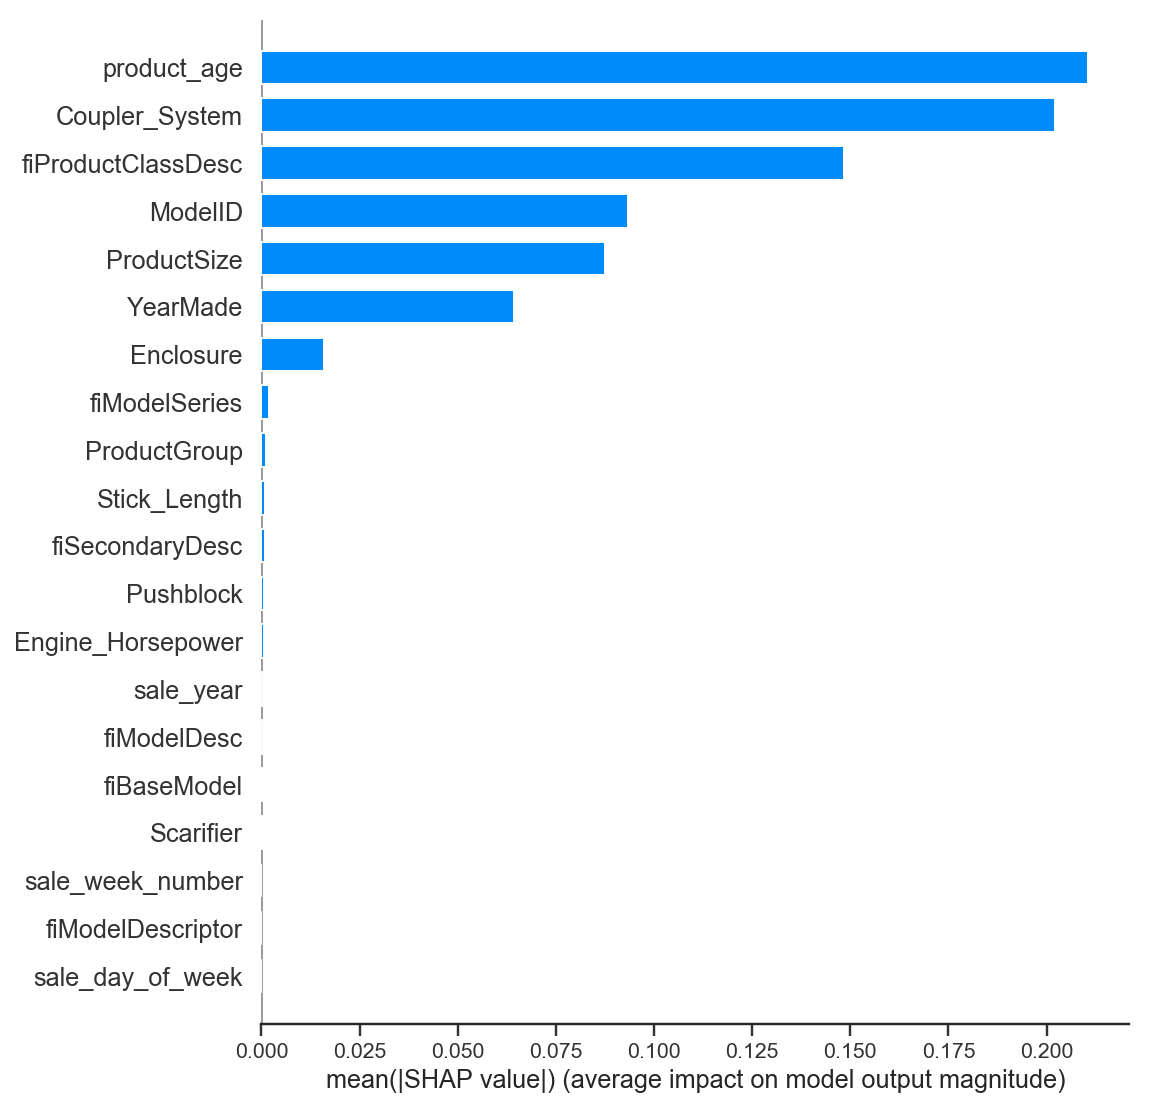

In [18]:
shap_values = shap.TreeExplainer(model).shap_values(MI_XTRAIN)
shap.summary_plot(shap_values, MI_XTRAIN, plot_type="bar")

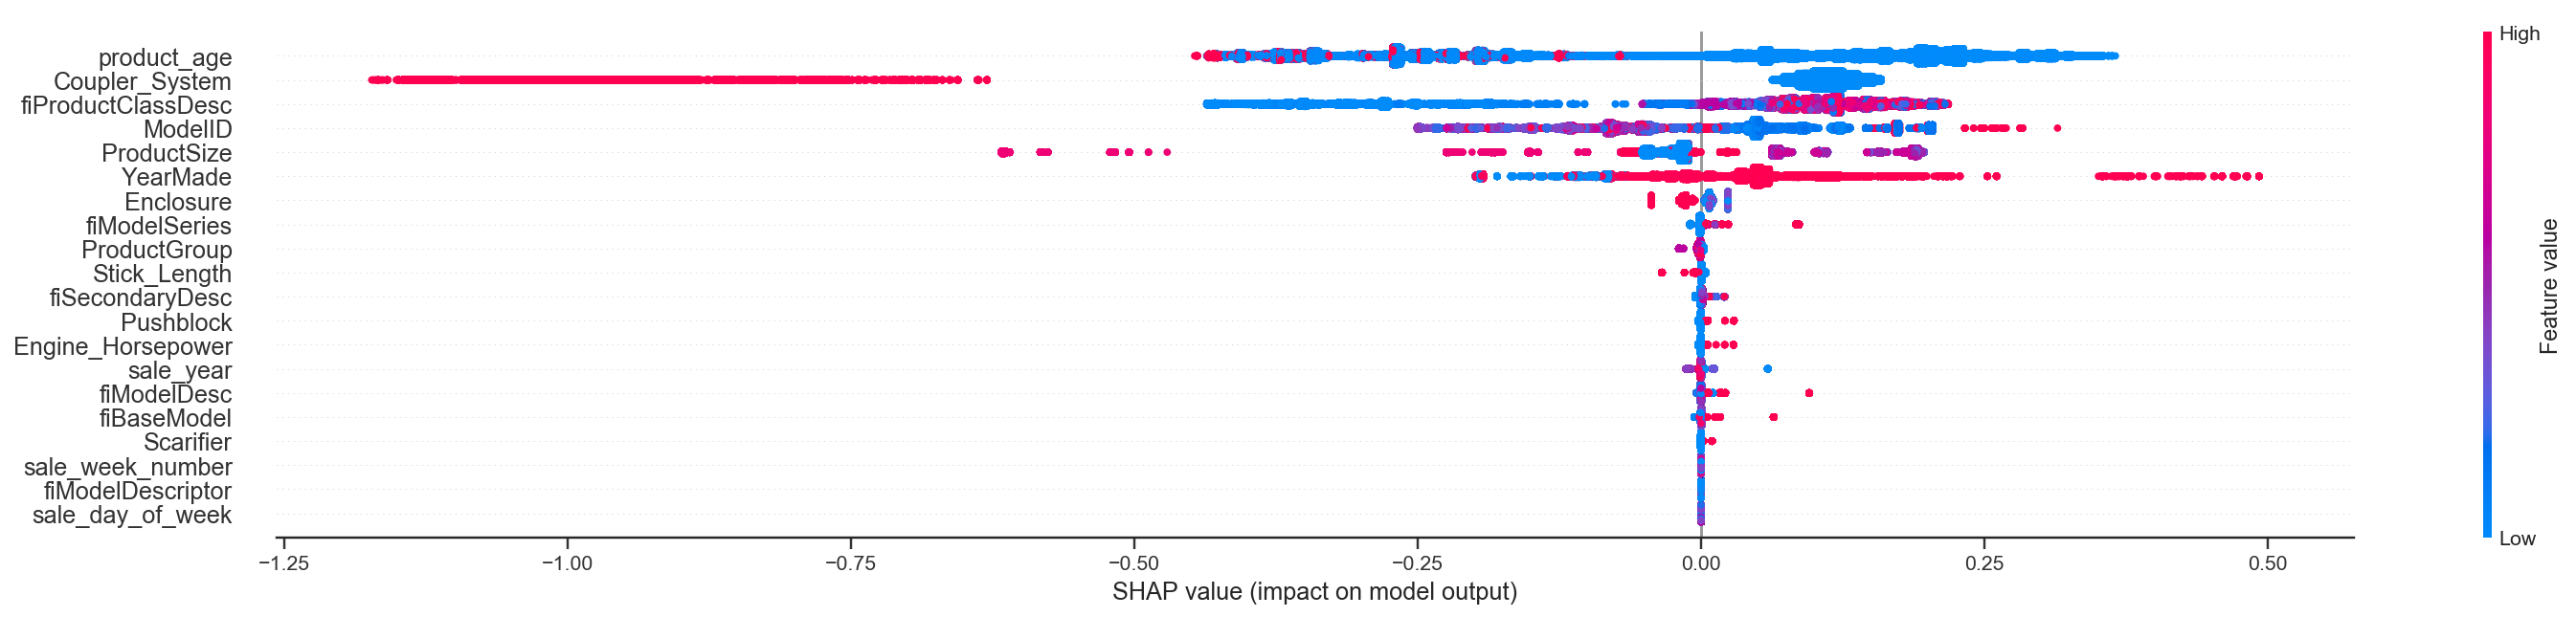

In [19]:
shap.summary_plot(shap_values, MI_XTRAIN, auto_size_plot = False)

In [21]:
idx = 99
explainerModel = shap.TreeExplainer(model)
shap.force_plot(explainerModel.expected_value, shap_values[idx], MI_XTRAIN.iloc[[idx]])

## LIME

In [41]:
categorical_cols = [k for k in categorical_mapping.keys()]

explainer = lime.lime_tabular.LimeTabularExplainer(MI_XTRAIN.values, 
                                                   feature_names=MI_XTRAIN.columns.tolist(), 
                                                   class_names=[TARGET_VARIABLE], 
                                                   categorical_features=categorical_cols, 
                                                   verbose=True, mode='regression')

In [43]:
idx = 999

exp = explainer.explain_instance(MI_XTRAIN.iloc[idx], model.predict, num_features=5)
exp.show_in_notebook(show_table=True)

Intercept 9.045397386616157
Prediction_local [9.35118702]
Right: 9.385470803567575


## PDP & ICE

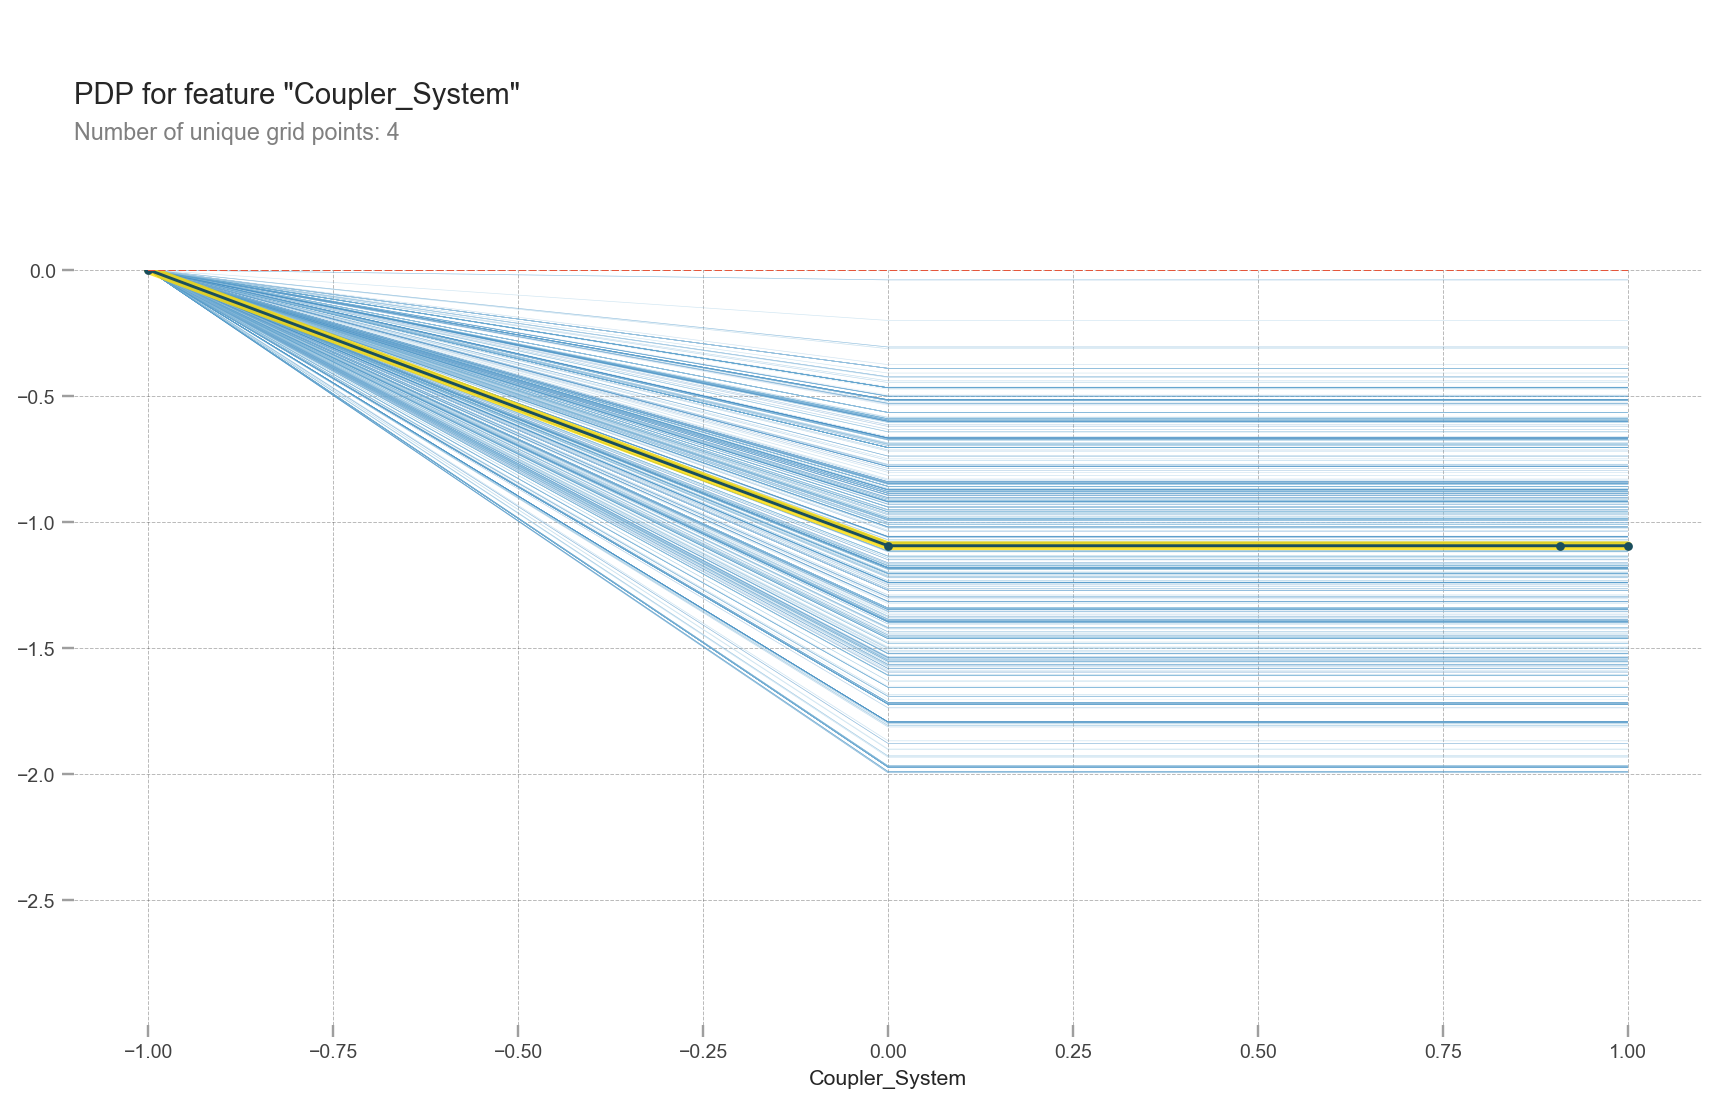

In [54]:
pdp_StoreType = pdp.pdp_isolate(model=model, 
                                dataset=MI_XTRAIN.sample(1000), 
                                num_grid_points = 100,
                                model_features=MI_XTRAIN.columns.tolist(), 
                                feature='Coupler_System')

fig, axes = pdp.pdp_plot(pdp_StoreType, 'Coupler_System', plot_lines=True)

## Tree Visualisations

In [36]:
tree_estimator = model.estimators_[0]

# Create DOT data
dot_data = tree.export_graphviz(tree_estimator, out_file=None,
                                feature_names=MI_XTRAIN.columns.tolist(),  
                                class_names=TARGET_VARIABLE)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())

# # Create PDF
graph.write_pdf(notebook_results_path+"decisionTreeViz.pdf")


True

# Random Testing Space

In [60]:
# Example of the Shapiro-Wilk Normality Test
from scipy.stats import shapiro
data = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]
stat, p = shapiro(data)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')


stat=0.895, p=0.193
Probably Gaussian


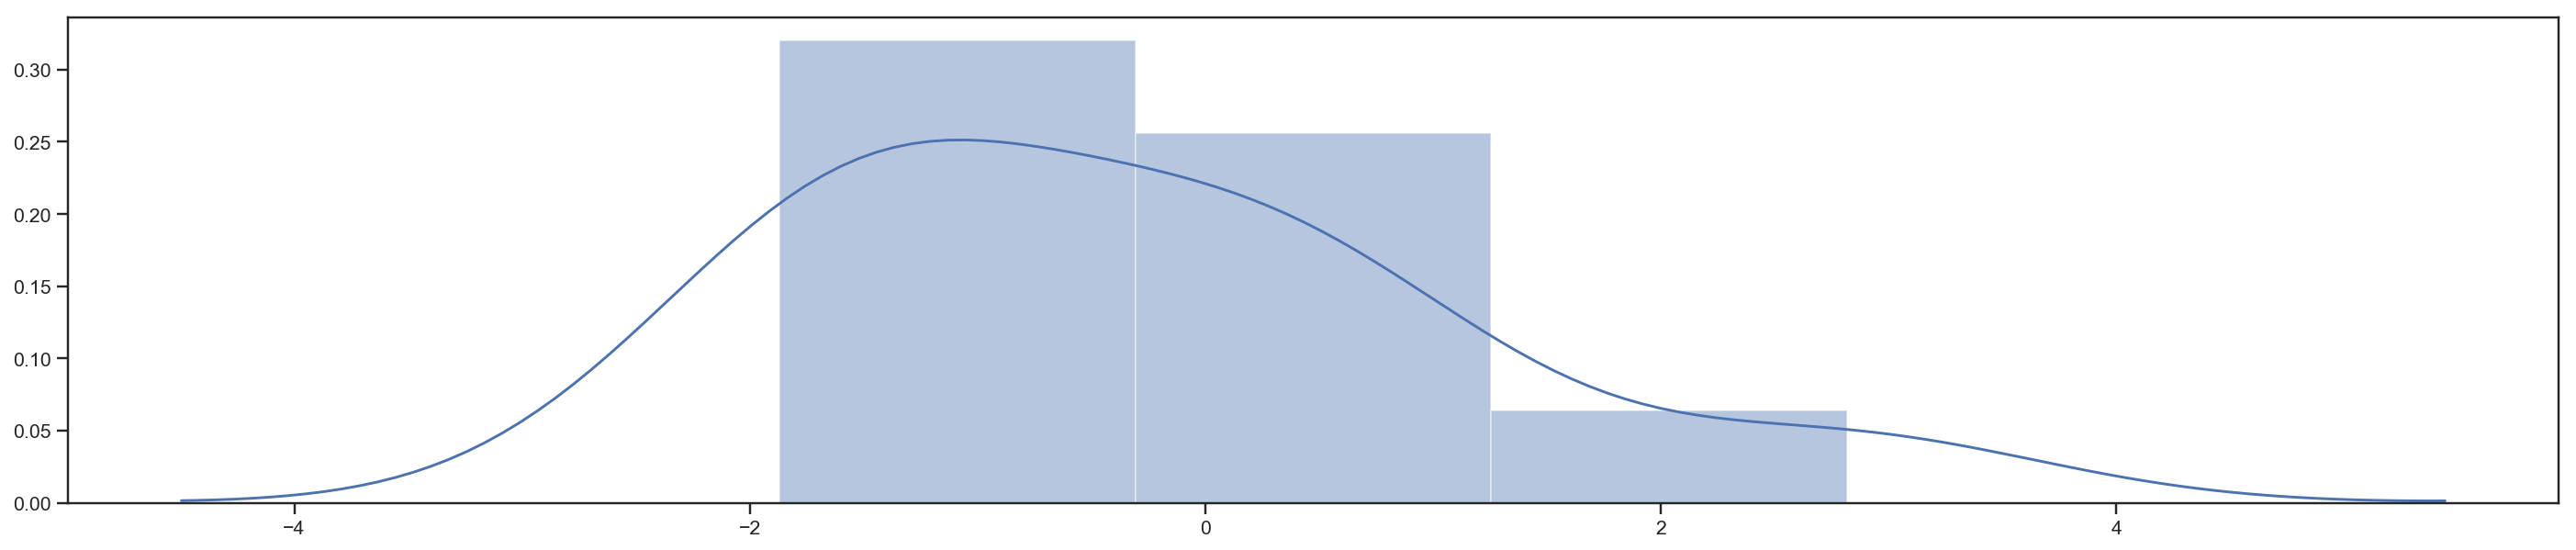

In [59]:
sns.distplot(data)